In [52]:
import re
import math
import pickle
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from time import time
import IPython.display as Disp
from wordcloud import WordCloud
from sklearn.metrics.pairwise import cosine_similarity
from gensim import corpora, models, similarities
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from underthesea import word_tokenize
from operator import itemgetter
import warnings
warnings.filterwarnings('ignore')

In [73]:
df = pd.read_csv('2k_data_Sep.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Feedback ID      2000 non-null   float64
 1   Lookup Text      2000 non-null   object 
 2   Question Text    2000 non-null   object 
 3   Feedback Type    2000 non-null   object 
 4   Feedback Result  2000 non-null   object 
 5   Human Feedback   2000 non-null   object 
 6   Lookup Image     2000 non-null   object 
 7   Question Image   2000 non-null   object 
dtypes: float64(1), object(7)
memory usage: 125.1+ KB


In [74]:
df.head()

,Feedback ID,Lookup Text,Question Text,Feedback Type,Feedback Result,Human Feedback,Lookup Image,Question Image
0,4416.0,b) \( \left(\frac{-4}{15}-\frac{18}{19}\right)...,a) \( \frac{2}{3}+\frac{-1}{3}+\frac{7}{15} \)...,NEGATIVE,MATCH,NOT MATCH,https://s3.icankid.io/uploads/question/9a7aa76...,https://s3.icankid.io/uploads/question/41bf56d...
1,4419.0,Đề số \( 1 . \)\n1. Tính\nb) \( \sqrt{25} \)\n...,b) \( \sqrt{25} \)\nc) \( \sqrt{-36} \)\na) \(...,NEGATIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/0398020...,https://s3.icankid.io/uploads/question/5a47b89...
2,4420.0,1. Tính: \( \sqrt{\frac{25}{4}}+\left(\sqrt{\f...,Đề số \( 3 . \)\n1. Tính: \( \sqrt{\frac{25}{4...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/a81b075...,https://s3.icankid.io/uploads/question/2d3358a...
3,4423.0,Câu 49: Cho hàm số \( y=f(x) \) có đạo hàm là ...,Câu 49. Cho hàm số \( y=f(x) \) có đạo hàm \( ...,NEGATIVE,NOT_MATCH,NOT MATCH,https://s3.icankid.io/uploads/question/a981260...,https://s3.icankid.io/uploads/question/aaa4976...
4,4425.0,b. Giải phương trình: \( 2 \sin ^{2} x+\sqrt{3...,1) \( \sin ^{2} 2 x-(2+\sqrt{3}) \sin 2 x+\sqr...,NEGATIVE,NOT_MATCH,NOT MATCH,https://s3.icankid.io/uploads/question/caa519f...,https://s3.icankid.io/uploads/question/7ea6f5f...


In [75]:
def clean_function(text):  
    #lowercase
    text = text.lower()
    
#     #xoá ký tự đặc biệt, ký tự không phải alphanumeric 
#     text = re.sub("[^a-z0-9àáạảãâầấậẩẫăằắặẳẵèéẹẻẽêềếệểễòóọỏõôồốộổỗơờớợởỡìíịỉĩùúụủũưừứựửữỳýỵỷỹđ]",' ', text)
    text = re.sub("[\àáạảãâầấậẩẫăằắặẳẵèéẹẻẽêềếệểễòóọỏõôồốộổỗơờớợởỡìíịỉĩùúụủũưừứựửữỳýỵỷỹđ]",'', text)

#     #xoá leading zero
#     text = [e.lstrip('0') for e in text.split(' ')]
#     text = (' ').join(text)
    
    #replace extra spaces with single space
    text = re.sub(' +',' ',text)
    
    #xoá khoảng trắng ở đầu và cuối mỗi câu
    text = text.strip()
    
    #word tokenzie
    text = word_tokenize(text, format='text')
    return text

In [76]:
df['index_org'] = df.index

df['clean_lookup'] = df['Lookup Text'].map(lambda x: clean_function(x))
df['clean_question'] = df['Question Text'].map(lambda x: clean_function(x))

df['char_count_lookup'] = df['clean_lookup'].str.len()
df['word_count_lookup'] = df['clean_lookup'].str.split().str.len()
df['average_word_length_lookup'] = df['char_count_lookup'] / df['word_count_lookup']

df['char_count_question'] = df['clean_question'].str.len()
df['word_count_question'] = df['clean_question'].str.split().str.len()
df['average_word_length_question'] = df['char_count_question'] / df['word_count_question']

In [77]:
check_dup = df[['Lookup Text', 'Question Text']][df[['Lookup Text', 'Question Text']].duplicated()]
df = df.drop(check_dup.index)
df = df.reset_index(drop = True)
df.shape

(1962, 17)

In [78]:
df['Human Feedback'].value_counts()

MATCH        996
NOT MATCH    966
Name: Human Feedback, dtype: int64

In [79]:
mask1 = df['Human Feedback'] == 'MATCH'

df_pos = df[mask1].reset_index(drop = True)
df_pos

,Feedback ID,Lookup Text,Question Text,Feedback Type,Feedback Result,Human Feedback,Lookup Image,Question Image,index_org,clean_lookup,clean_question,char_count_lookup,word_count_lookup,average_word_length_lookup,char_count_question,word_count_question,average_word_length_question
0,4419.0,Đề số \( 1 . \)\n1. Tính\nb) \( \sqrt{25} \)\n...,b) \( \sqrt{25} \)\nc) \( \sqrt{-36} \)\na) \(...,NEGATIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/0398020...,https://s3.icankid.io/uploads/question/5a47b89...,1,s \ ( 1_._\ ) 1_._tnh b ) \ ( \ sqrt { 25 }_\ ...,b ) \ ( \ sqrt { 25 }_\ ) c ) \ ( \ sqrt { - 3...,390,129,3.023256,400,131,3.053435
1,4420.0,1. Tính: \( \sqrt{\frac{25}{4}}+\left(\sqrt{\f...,Đề số \( 3 . \)\n1. Tính: \( \sqrt{\frac{25}{4...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/a81b075...,https://s3.icankid.io/uploads/question/2d3358a...,2,1_._tnh : \ ( \ sqrt {_\ frac { 25 }_{ 4 } }_+...,s \ ( 3 . \ ) 1_._tnh : \ ( \ sqrt {_\ frac { ...,229,73,3.136986,243,80,3.037500
2,4432.0,25. Tìm giá trị x (làm tròn đến chữ số thập ph...,b) Canh BC.\n5. Tìm giá trị \( x \) (làm tròn ...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/71b3a3c...,https://s3.icankid.io/uploads/question/3c3ec9e...,7,25 ._tm gi tr x ( lm trn n ch s thp phn th ba ...,b ) canh bc . 5 . tm gi tr \ ( x \ ) ( lm trn ...,119,36,3.305556,134,45,2.977778
3,4443.0,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/690df82...,https://s3.icankid.io/uploads/question/44a094e...,11,cu 6 . cho \ ( \ frac { x-6 }_{ 1998 }_+_\ fra...,cu 6 . cho \ ( \ frac { x-6 }_{ 1998 }_+_\ fra...,217,72,3.013889,216,72,3.000000
4,4446.0,Câu 7. Các giá trị của \( x \) thỏa mã \( \lef...,Câu 7. Các giá trị của \( x \) thỏa mãn \( \le...,POSITIVE,SKIP,MATCH,https://s3.icankid.io/uploads/question/539c341...,https://s3.icankid.io/uploads/question/eb404dc...,13,cu 7 . cc gi tr ca \ ( x \ ) tha m \ ( \_left ...,cu 7 . cc gi tr ca \ ( x \ ) tha mn \ ( \_left...,418,153,2.732026,419,153,2.738562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,9955.0,3.36. Cho biết tích của hai số tự nhiên \( n \...,3.36. Cho biết tích của hai số tự nhiên \( n \...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/a08206d...,https://s3.stag.icankids.com.vn/uploads/questi...,1989,3.36 . cho bit tch ca hai s t nhin \ ( n \ ) v...,3.36 . cho bit tch ca hai s t nhin \ ( n \ ) v...,135,49,2.755102,143,53,2.698113
992,9967.0,"Câu 10: Trong hệ trục Oxy, cho \( \vec{u}=(-2 ...","Câu 18: Trong mặt phẳng tọa độ \( O x y \), ch...",NEGATIVE,SKIP,MATCH,https://s3.icankid.io/uploads/question/d34ea5b...,https://s3.icankid.io/uploads/question/d44ded4...,1992,"cu 10 : trong h trc oxy , cho \ ( \ vec {_u }_...","cu 18 : trong mt phng ta \ ( o x y \ ) , cho \...",226,99,2.282828,234,100,2.340000
993,9973.0,6. Hai đoạn ống nước có chiều dài lần lượt là ...,6. Hai đoạn ống nước có chiều dài lần lượt là ...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/f60a06b...,https://s3.icankid.io/uploads/question/2740c6d...,1994,"6 . hai on ng nc c chiu di_ln lt l \ ( 0,8 m \...","6 . hai on ng nc c chiu di_ln lt l \ ( 0,8 m \...",201,62,3.241935,198,61,3.245902
994,9978.0,"bao nhiêu phần kế hoạch?\n8. Vào tháng 6, giá ...","8. Vào tháng 6 , giá niêm yết một chiếc ti vi ...",POSITIVE,SKIP,MATCH,https://s3.icankid.io/uploads/question/9fee271...,https://s3.icankid.io/uploads/question/9363c3c...,1995,"bao nhiu phn k hoch ? 8 ._vo thng 6 , gi nim y...","8 ._vo thng 6 , gi nim yt mt chic ti vi 42 inc...",336,99,3.393939,314,93,3.376344


In [59]:
with open('vietnamese-stopwords.txt', 'r', encoding='utf-8') as file:
    vn_stop_words = file.read()
vn_stop_words = vn_stop_words.split('\n') 

# combine Vietnamese stopwords and English stopwords
stop_words = ENGLISH_STOP_WORDS.union(vn_stop_words)

In [124]:
tf = TfidfVectorizer(analyzer = 'word', stop_words = stop_words, max_features = 1200)
tf = tf.fit(df_pos['clean_question'])
tfidf_matrix = tf.transform(df_pos['clean_question'])
tfidf_matrix.shape

(996, 1200)

In [125]:
tfidf_matrix = pd.DataFrame(tfidf_matrix.toarray(),
                            columns = tf.get_feature_names())
tfidf_matrix.head()

,00,000_,004_,00_,01,036_,04_,06,07,08,...,yy,z_,zip,ĺn,ба7,эn,कf_,जics,द_,ḿt
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [94]:
sums_weight = tfidf_matrix.sum().sort_values(ascending = False)
sums_weight.head(20)

frac      97.894519
sqrt      63.931901
_right    41.350716
_left     40.254239
ca        39.427528
a_        38.472291
cc        36.976064
3_        31.638730
y_        30.780279
ng        29.235738
hnh       27.861221
mt        26.422596
cu        24.928638
tr        23.714012
10        23.501580
tp        23.250181
gi        23.008657
tnh       22.852037
nh        22.378509
hp        22.342902
dtype: float64

In [95]:
def cosine_search_all(queries, tfidf_matrix, data, top_result = 5, check_time = True):
    t0 = time()
    results = pd.DataFrame(columns = ['lookup_text', 'question_text', 'sim_score', 'cosine_word_count_question'])
    for q in queries:
        query = clean_function(q)
        query_tf = tf.transform([query])
        query_tf = pd.DataFrame(query_tf.toarray(),
                                columns = tf.get_feature_names())
        cosine_sim = cosine_similarity(query_tf, tfidf_matrix).flatten()
        related_index = cosine_sim.argsort()[-top_result:][::-1]
        cosine_sim = sorted(cosine_sim, reverse = True)
        similarities_score = cosine_sim[:top_result]
        result = pd.DataFrame({'lookup_text': q,
                               'question_text': data.iloc[related_index, :]['Question Text'].values,
                               'sim_score': similarities_score,
                               'cosine_word_count_question': data.iloc[related_index, :]['word_count_question'].values}).head(1)
        results = pd.concat([results, result], ignore_index = True)
    if check_time:
        print('Time:', time() - t0)
    return results

In [126]:
result_all = cosine_search_all(df_pos['Lookup Text'], tfidf_matrix, df_pos)

Time: 15.453986167907715


In [65]:
result_all

,lookup_text,question_text,sim_score,cosine_word_count_question
0,Đề số \( 1 . \)\n1. Tính\nb) \( \sqrt{25} \)\n...,b) \( \sqrt{25} \)\nc) \( \sqrt{-36} \)\na) \(...,0.920767,131
1,1. Tính: \( \sqrt{\frac{25}{4}}+\left(\sqrt{\f...,Đề số \( 3 . \)\n1. Tính: \( \sqrt{\frac{25}{4...,1.0,81
2,25. Tìm giá trị x (làm tròn đến chữ số thập ph...,b) Canh BC.\n5. Tìm giá trị \( x \) (làm tròn ...,0.715035,59
3,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,0.997316,73
4,Câu 7. Các giá trị của \( x \) thỏa mã \( \lef...,Câu 7. Các giá trị của \( x \) thỏa mãn \( \le...,1.0,157
...,...,...,...,...
991,3.36. Cho biết tích của hai số tự nhiên \( n \...,3.36. Cho biết tích của hai số tự nhiên \( n \...,0.978664,62
992,"Câu 10: Trong hệ trục Oxy, cho \( \vec{u}=(-2 ...","Câu 18: Trong mặt phẳng tọa độ \( O x y \), ch...",0.551084,103
993,6. Hai đoạn ống nước có chiều dài lần lượt là ...,6. Hai đoạn ống nước có chiều dài lần lượt là ...,0.985693,90
994,"bao nhiêu phần kế hoạch?\n8. Vào tháng 6, giá ...","8. Vào tháng 6 , giá niêm yết một chiếc ti vi ...",0.991957,134


In [127]:
df_pos['search_result'] = result_all['question_text']
df_pos['score'] = result_all['sim_score']
df_pos['cosine_word_count_question'] = result_all['cosine_word_count_question']

In [17]:
# df_pos = df_pos[['Feedback ID', 'Lookup Text', 'Question Text', 
#                  'search_result', 'score', 'Feedback Type', 'Human Feedback',
#                  'Lookup Image', 'Question Image']]

In [18]:
df_pos.head()

,Feedback ID,Lookup Text,Question Text,Feedback Type,Feedback Result,Human Feedback,Lookup Image,Question Image,index_org,clean_lookup,clean_question,char_count_lookup,word_count_lookup,average_word_length_lookup,char_count_question,word_count_question,average_word_length_question,search_result,score,cosine_word_count_question
0,4419.0,Đề số \( 1 . \)\n1. Tính\nb) \( \sqrt{25} \)\n...,b) \( \sqrt{25} \)\nc) \( \sqrt{-36} \)\na) \(...,NEGATIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/0398020...,https://s3.icankid.io/uploads/question/5a47b89...,1,đề số \ ( 1_._\ ) 1_._tính b ) \ ( \ sqrt { 25...,b ) \ ( \ sqrt { 25 }_\ ) c ) \ ( \ sqrt { - 3...,395,130,3.038462,400,131,3.053435,b) \( \sqrt{25} \)\nc) \( \sqrt{-36} \)\na) \(...,0.908561,131
1,4420.0,1. Tính: \( \sqrt{\frac{25}{4}}+\left(\sqrt{\f...,Đề số \( 3 . \)\n1. Tính: \( \sqrt{\frac{25}{4...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/a81b075...,https://s3.icankid.io/uploads/question/2d3358a...,2,1_._tính : \ ( \ sqrt {_\ frac { 25 }_{ 4 } }_...,đề số \ ( 3 . \ ) 1_._tính : \ ( \ sqrt {_\ fr...,230,73,3.150685,248,81,3.061728,Đề số \( 3 . \)\n1. Tính: \( \sqrt{\frac{25}{4...,0.965204,81
2,4432.0,25. Tìm giá trị x (làm tròn đến chữ số thập ph...,b) Canh BC.\n5. Tìm giá trị \( x \) (làm tròn ...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/71b3a3c...,https://s3.icankid.io/uploads/question/3c3ec9e...,7,25 . tìm giá_trị x ( làm tròn đến chữ_số thập_...,b ) canh bc . 5 . tìm giá_trị \ ( x \ ) ( làm ...,146,31,4.709677,160,41,3.902439,b) Canh BC.\n5. Tìm giá trị \( x \) (làm tròn ...,0.387851,41
3,4443.0,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/690df82...,https://s3.icankid.io/uploads/question/44a094e...,11,câu 6 . cho \ ( \ frac { x-6 }_{ 1998 }_+_\ fr...,câu 6 . cho \ ( \ frac { x-6 }_{ 1998 }_+_\ fr...,219,72,3.041667,218,72,3.027778,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,0.964331,72
4,4446.0,Câu 7. Các giá trị của \( x \) thỏa mã \( \lef...,Câu 7. Các giá trị của \( x \) thỏa mãn \( \le...,POSITIVE,SKIP,MATCH,https://s3.icankid.io/uploads/question/539c341...,https://s3.icankid.io/uploads/question/eb404dc...,13,câu 7 . các giá_trị của \ ( x \ ) thỏa mã \ ( ...,câu 7 . các giá_trị của \ ( x \ ) thỏa_mãn \ (...,425,152,2.796053,426,151,2.821192,Câu 7. Các giá trị của \( x \) thỏa mãn \( \le...,0.911555,151


In [128]:
mask2 = df_pos['Question Text'] != df_pos['search_result']

df_check = df_pos[mask2]
df_check.shape

(62, 20)

In [68]:
def cosine_noPCA(query, tfidf_matrix, top_result = 5, check_time = True):
    t0 = time()
    query = clean_function(query)
    query_tf = tf.transform([query])
    query_tf = pd.DataFrame(query_tf.toarray(),
                            columns = tf.get_feature_names())
    
    cosine_sim = cosine_similarity(query_tf, tfidf_matrix).flatten()
    
    related_question = cosine_sim.argsort()[-top_result:][::-1]
    
    cosine_sim = sorted(cosine_sim, reverse = True)
    similarities_score = cosine_sim[:top_result]
    
    result = pd.DataFrame({'question_text': df_pos.iloc[related_question, :]['Question Text'].values,
                           'sim_score': similarities_score})
    if check_time:
        print('Time:', time() - t0)
    return result

In [21]:
df_check.iloc[0]['Lookup Text']

'5. Một đội thannh nien tinh nguyện có \\( 13 \\theta \\) ñgườ can thue o to de di chuyen. Họ can wué ít nhất bao nhiêu xe nếu mỗi xe chở được 45 người?'

In [22]:
cosine_noPCA(df_check.iloc[1]['Lookup Text'], tfidf_matrix)

Time: 0.035234928131103516


,question_text,sim_score
0,15) \( \sqrt{3} \cos 5 x-2 \sin 3 x \cdot \cos...,0.845979
1,Chứng minh biểu thức sau không phụ thuộc vào \...,0.817970
2,12. \( 2 \sin ^{2} x+\sin x \cos x-\cos ^{2} x...,0.803772
3,\( 8 \sin 2 x-\cos 2 x+3 \sin x-\cos x-1=0 \),0.718512
4,Ví dụ 3. Chứng minh rằng trong tam giác \( A B...,0.699978


In [23]:
df_check.index.tolist()[0]

9

In [24]:
len(df_check.index)

103

In [25]:
idx = list(range(0, len(df_check.index)))
idx[:5]

[0, 1, 2, 3, 4]

In [26]:
type(idx)

list

In [99]:
def check_wrong_results(indices):
    index_ = df_check.index.tolist()
    no_results = []
    top5_results = []
    for num in indices:
        df_results = cosine_noPCA(df_check.iloc[num]['Lookup Text'], tfidf_matrix, check_time = False)
        top_results = df_results['question_text'].values
        if (df_check.iloc[num]['Lookup Text'] in top_results) or (df_check.iloc[num]['Question Text'] in top_results):
            top5_results.append(index_[num])
        else:
            no_results.append(index_[num])
    return top5_results, no_results

In [122]:
top5_result, no_result = check_wrong_results(list(range(0, len(df_check.index))))

In [123]:
print(len(top5_result))
print(len(no_result))

40
24


In [109]:
mask3 = df_pos['Question Text'] == df_pos['search_result']

df_match = df_pos[mask3]
df_match.shape

(934, 20)

In [90]:
df_top5 = df_pos.iloc[top5_result, :]
df_top5.shape

(36, 20)

In [91]:
df_no = df_pos.iloc[no_result, :]
df_no.shape

(26, 20)

In [33]:
df_no['Feedback Type'].value_counts()

NEGATIVE    21
POSITIVE    21
Name: Feedback Type, dtype: int64

In [34]:
df_no

,Feedback ID,Lookup Text,Question Text,Feedback Type,Feedback Result,Human Feedback,Lookup Image,Question Image,index_org,clean_lookup,clean_question,char_count_lookup,word_count_lookup,average_word_length_lookup,char_count_question,word_count_question,average_word_length_question,search_result,score,cosine_word_count_question
12,4496.0,\( \sqrt{3} \sin x+\cos x+\cos 5 x+2(\cos 6 x+...,Đề 117: Giải phương trình: \( \sqrt{3} \sin (x...,NEGATIVE,NOT_MATCH,MATCH,https://s3.icankid.io/uploads/question/bb4ed6f...,https://s3.icankid.io/uploads/question/bc6bb8a...,31,\ ( \ sqrt { 3_}_\ sin x + \ cos x + \ cos 5 x...,đề 117 : giải phương_trình : \ ( \ sqrt { 3_}_...,97,36,2.694444,134,43,3.116279,15) \( \sqrt{3} \cos 5 x-2 \sin 3 x \cdot \cos...,0.845979,28
24,4543.0,Câu 37. Hàm số nào đồng biến trên khoảng \( (-...,D. Hàm số nghịh bich trểa caic kên khoảng \( (...,NEGATIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/f9190b3...,https://s3.icankid.io/uploads/question/9600bf5...,50,câu 37 . hàm_số nào đồng_biến trên khoảng \ ( ...,d . hàm_số nghịh bich trểa caic kên khoảng \ (...,237,76,3.118421,226,72,3.138889,Câu 13. Tập họp tất cả các giá trị của tham số...,0.657468,98
54,4674.0,\( 2 x-2^{0}=3^{5}: 3^{3} \),f) \( 2 x-2^{0}=3^{5}: 3^{3} \),POSITIVE,NOT_MATCH,MATCH,https://s3.icankid.io/uploads/question/90ea4e0...,https://s3.icankid.io/uploads/question/91a64b0...,99,\ ( 2 x-2 ^_{ 0 } = 3 ^ { 5 } : 3 ^ { 3 }_\ ),f ) \ ( 2 x-2 ^_{ 0 } = 3 ^ { 5 } : 3 ^ { 3 }_\ ),45,20,2.250000,49,22,2.227273,"Ví dụ 3: Cho tam giác \( A B C \). Gọi \( M , ...",0.0,153
95,4926.0,Fer 1\na) \( x^{2}\left(5 x^{2}-x-\frac{1}{2}\...,1. Làm tính nhân :\na) \( x^{2}\left(5 x^{3}-x...,NEGATIVE,NOT_MATCH,MATCH,https://s3.icankid.io/uploads/question/ab47cdc...,https://s3.icankid.io/uploads/question/3be66f0...,176,fer 1 a ) \ ( x ^ { 2 }_\_left ( 5 x ^ { 2 } -...,1_. làm tính nhân : a ) \ ( x ^ { 2 }_\_left (...,83,32,2.593750,97,33,2.939394,Bài 2.4. Tìm các số hữu tỉ \( x \) biết:\na) \...,0.955045,135
122,5061.0,Câu 17. Trong mặt phẳng \( Oxy \) cho \( \over...,"Câu 3: Trong mát phẳng toa đô \( O n y \), cho...",NEGATIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/bbf8f61...,https://s3.icankid.io/uploads/question/f5c9947...,224,câu 17 . trong mặt_phẳng \ ( oxy_\ ) cho \ ( \...,"câu 3 : trong mát phẳng toa đô \ ( o n y \ ) ,...",284,101,2.811881,296,106,2.792453,Câu 5: Trong mặt phằng \( Oxy \) cho hàm số \(...,0.571943,61
127,5099.0,a) \( x^{2}\left(5 x^{3}-x-\frac{1}{2}\right) \),1. Làm tính nhân :\na) \( x^{2}\left(5 x^{3}-x...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/b967b42...,https://s3.icankid.io/uploads/question/3be66f0...,236,a ) \ ( x ^ { 2 }_\_left ( 5 x ^_{ 3_} - x - \...,1_. làm tính nhân : a ) \ ( x ^ { 2 }_\_left (...,77,28,2.750000,97,33,2.939394,a) Tính: \( \left(\frac{-1}{2}\right)^{5} ;\le...,0.978722,141
131,5123.0,Cov M Ha tḥp hop các só tư nhiên lón hơn 6 và ...,Luyẹ tạp 3\nGọi \( M \) là tập hợ các số tự nh...,NEGATIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/8a2684f...,https://s3.icankid.io/uploads/question/b89da74...,241,cov m ha tḥp hop các só tư_nhiên lón hơn 6 và ...,luyẹ tạp 3 gọi \ ( m \ ) là tập hợ các số tự_n...,95,24,3.958333,201,68,2.955882,Luyẹn tḥp 2\nTính nhẩm: \( 125 \cdot 8001 \cdo...,0.183119,13
137,5136.0,\( \sqrt{x+2-3 \sqrt{2 x-5}}+\sqrt{x-2+\sqrt{2...,d)\n\[\n\sqrt{x+2+3 \sqrt{2 x-5}}+\sqrt{x-2-\s...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/a06ff21...,https://s3.icankid.io/uploads/question/d4b1fa2...,249,\ ( \ sqrt { x + 2-3_\_sqrt { 2 x-5 }_}_+_\ sq...,d ) \_[_\ sqrt { x + 2 + 3 \ sqrt { 2 x-5 }_}_...,96,31,3.096774,102,33,3.090909,Bài 9: Tính\na) \( (\sqrt{5})^{2} \)\nb) \( (\...,0.960948,72
241,5693.0,\( U=\{x \in N \mid x \) chia hết cho 3\( \} \...,1.2. Cho tập hợp\n\( U=\{x \in N \mid x \) chi...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/91aedca...,https://s3.icankid.io/uploads/question/3d2ac53...,456,\ ( u =_\_{ x \ in n \ mid x \ ) chia

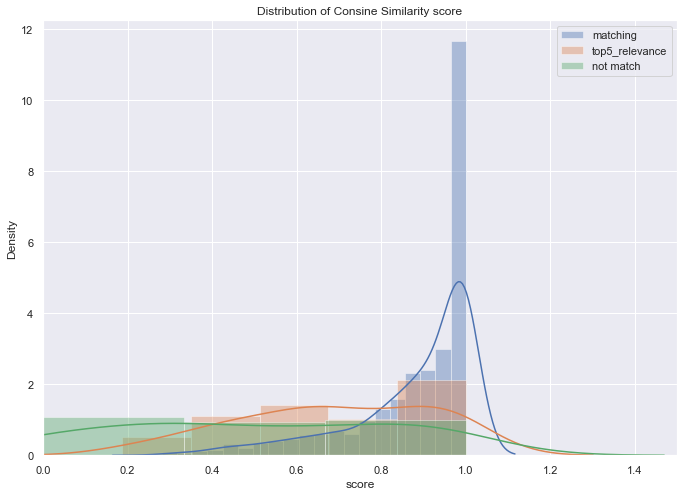

In [35]:
sb.set_theme()
plt.figure(figsize=(25,8))
plt.subplot(121)
sb.distplot(df_match.score, label = 'matching')
plt.subplot(121)
sb.distplot(df_top5.score, label = 'top5_relevance')
plt.subplot(121)
sb.distplot(df_no.score, label = "not match")
plt.xlim([0, 1.5])
plt.legend()
plt.title('Distribution of Consine Similarity score')
plt.show()

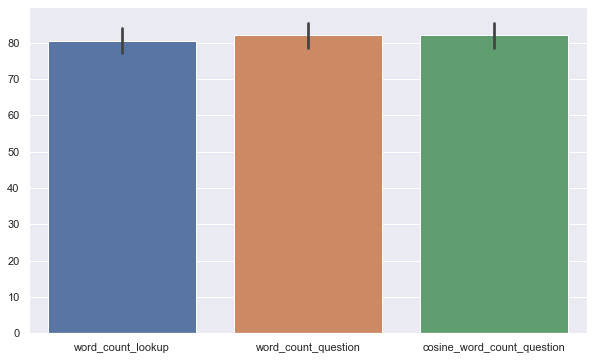

In [36]:
plt.figure(figsize=(10, 6))
sb.barplot(data = df_match[['word_count_lookup', 'word_count_question', 'cosine_word_count_question']]);

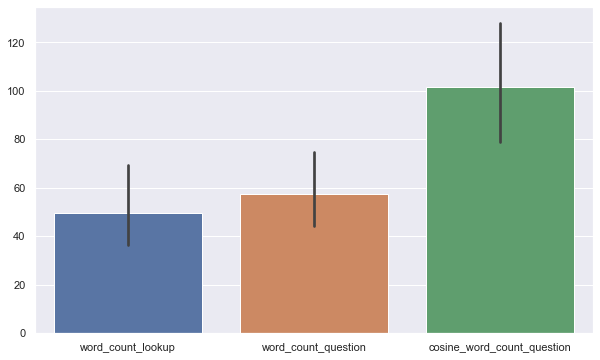

In [37]:
plt.figure(figsize=(10, 6))
sb.barplot(data = df_no[['word_count_lookup', 'word_count_question', 'cosine_word_count_question']]);

In [38]:
(1021 - len(no_result)) / 1021 * 100

95.88638589618022

In [39]:
df = pd.read_csv('2k_data_Sep.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Feedback ID      2000 non-null   float64
 1   Lookup Text      2000 non-null   object 
 2   Question Text    2000 non-null   object 
 3   Feedback Type    2000 non-null   object 
 4   Feedback Result  2000 non-null   object 
 5   Human Feedback   2000 non-null   object 
 6   Lookup Image     2000 non-null   object 
 7   Question Image   2000 non-null   object 
dtypes: float64(1), object(7)
memory usage: 125.1+ KB


In [40]:
df['index_org'] = df.index

df['clean_lookup'] = df['Lookup Text'].map(lambda x: clean_function(x))
df['clean_question'] = df['Question Text'].map(lambda x: clean_function(x))

df['char_count_lookup'] = df['clean_lookup'].str.len()
df['word_count_lookup'] = df['clean_lookup'].str.split().str.len()
df['average_word_length_lookup'] = df['char_count_lookup'] / df['word_count_lookup']

df['char_count_question'] = df['clean_question'].str.len()
df['word_count_question'] = df['clean_question'].str.split().str.len()
df['average_word_length_question'] = df['char_count_question'] / df['word_count_question']

check_dup = df[['Lookup Text', 'Question Text']][df[['Lookup Text', 'Question Text']].duplicated()]
df = df.drop(check_dup.index)
df = df.reset_index(drop = True)

mask1 = df['Human Feedback'] == 'MATCH'

df_pos = df[mask1].reset_index(drop = True)
df_pos.shape

(996, 17)

In [41]:
tf = TfidfVectorizer(analyzer = 'word', stop_words = stop_words, max_features = 1000)
tfidf_matrix = tf.fit_transform(df_pos['clean_question'])
tfidf_matrix = pd.DataFrame(tfidf_matrix.toarray(),
                            columns = tf.get_feature_names())
tfidf_matrix.shape

(996, 1000)

In [42]:
sums_weight = tfidf_matrix.sum().sort_values(ascending = False)
sums_weight.head(20)

frac       101.051348
sqrt        66.742949
_right      42.673571
_left       41.682331
a_          40.001877
3_          32.933126
y_          32.569605
10          24.967697
câu         24.569947
_a          22.326774
cdot        22.073318
sin         21.626743
_b          20.891799
hàm_số      18.561817
tập_hợp     18.207512
hai         18.167312
cos         18.039927
circ        17.994981
_c          17.860300
2_          17.765864
dtype: float64

In [43]:
# tf = TfidfVectorizer(analyzer = 'word', stop_words = stop_words, ngram_range = (2, 2))
# tfidf_matrix = tf.fit_transform(df_pos['clean_question'])
# tfidf_matrix = pd.DataFrame(tfidf_matrix.toarray(),
#                             columns = tf.get_feature_names())

# sums = tfidf_matrix.sum().sort_values(ascending = False)
# sums.head(20)

In [44]:
result_all = cosine_search_all(df_pos['Lookup Text'], tfidf_matrix, df_pos)
df_pos['search_result'] = result_all['question_text']
df_pos['score'] = result_all['sim_score']
df_pos['cosine_word_count_question'] = result_all['cosine_word_count_question']

Time: 12.997513055801392


In [45]:
top5_result, no_result = check_wrong_results(list(range(0, len(df_check.index))))

print(len(top5_result))
print(len(no_result))

66
37


In [46]:
mask3 = df_pos['Question Text'] == df_pos['search_result']

df_match = df_pos[mask3]
df_match.shape

(888, 20)

In [47]:
df_top5 = df_pos.iloc[top5_result, :]
df_top5.shape

(66, 20)

In [48]:
df_no = df_pos.iloc[no_result, :]
df_no.shape

(37, 20)

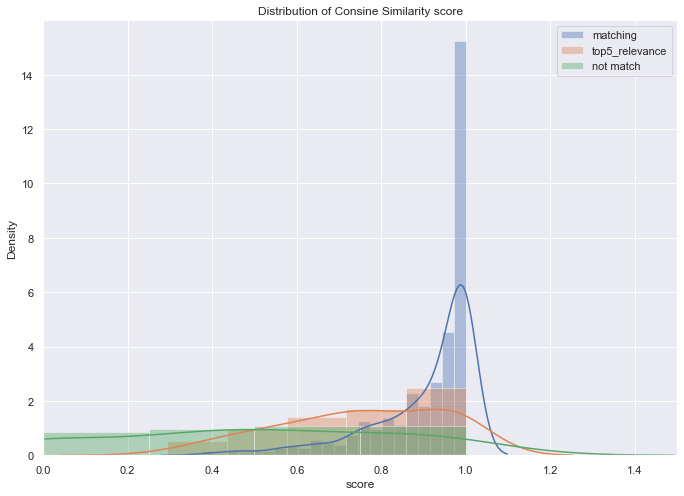

In [49]:
sb.set_theme()
plt.figure(figsize=(25,8))
plt.subplot(121)
sb.distplot(df_match.score, label = 'matching')
plt.subplot(121)
sb.distplot(df_top5.score, label = 'top5_relevance')
plt.subplot(121)
sb.distplot(df_no.score, label = "not match")
plt.xlim([0, 1.5])
plt.legend()
plt.title('Distribution of Consine Similarity score')
plt.show()

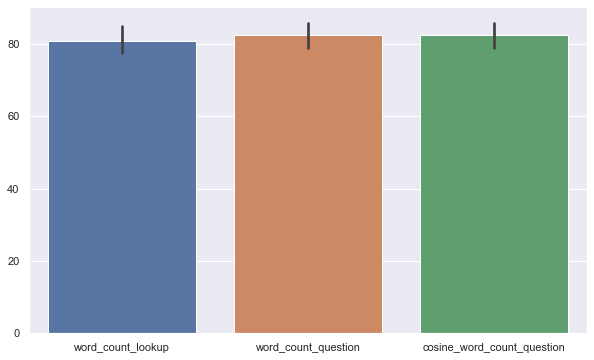

In [50]:
plt.figure(figsize=(10, 6))
sb.barplot(data = df_match[['word_count_lookup', 'word_count_question', 'cosine_word_count_question']]);

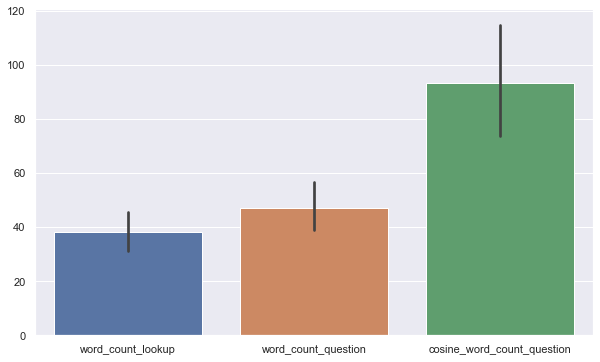

In [51]:
plt.figure(figsize=(10, 6))
sb.barplot(data = df_no[['word_count_lookup', 'word_count_question', 'cosine_word_count_question']]);

In [ ]:
df['Human Feedback'].value_counts()

In [ ]:
mask_ = df['Human Feedback'] != 'MATCH'
df_neg = df[mask_].reset_index(drop = True)
df_neg.shape

In [ ]:
df_neg.head()

In [ ]:
source = df_pos['Lookup Text'].values

neg_index = []

In [ ]:
for i in range(len(df_neg['Lookup Text'].values)):
    if df_neg.iloc[i]['Lookup Text'] in source:
        neg_index.append(i)

In [ ]:
len(neg_index)

In [ ]:
len(df_neg['Lookup Text'].values)

In [ ]:
df_neg['Lookup Text'].values[0]

In [ ]:
df_neg.iloc[neg_index, :]